<a href="https://colab.research.google.com/github/AndreassOlsson/drone-anomalydetection/blob/main/VisionTransformer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

%matplotlib inline

### Create DataLoader for MNIST dataset

In [ ]:
transform = ToTensor()

train_dset = MNIST(root='./mnist', train=True, download=True, transform=transform) 
test_dset = MNIST(root='./mnist', train=False, download=True, transform=transform) 

train_dl = DataLoader(train_dset, shuffle=True, batch_size=128)
test_dl = DataLoader(test_dset, shuffle=False, batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [ ]:
train_dl.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_dl.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist
    Split: Test
    StandardTransform
Transform: ToTensor()

### Define VisionTransformer model class

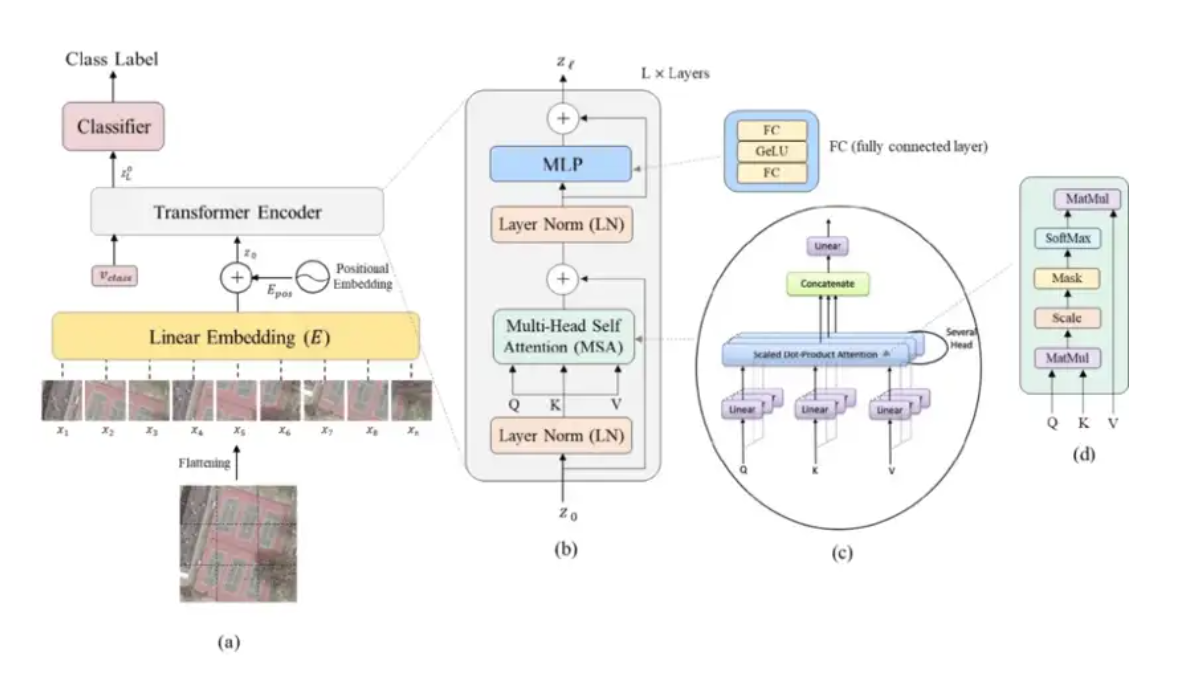

#### Patchify & Linear mapping

We reshape our input from shape (N, C=1, H=28, W=28) to shape (N, #Patches, Patch dimensionality).

We will divide our input image to 7x7=49 separate patches of size 1x4x4=16 giving us the new shape (N, 49, 16)

In [ ]:
def patchify(images, n_patches):
  n, c, h, w = images.shape

  assert h == w, "Patchify function only works for square images"
    
  patch_size = h // n_patches
  return torch.stack([torch.stack([image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size][0].flatten() for i in range(n_patches) for j in range(n_patches)]) for image in images])

#### Positional embedding

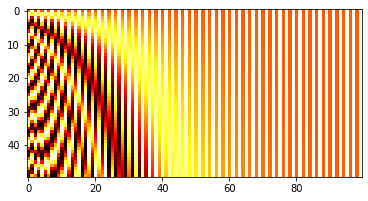

In [ ]:
"""
Allows the model to understand where each patch would be placed in the original image. In each sequence,
for token i, we add its j-th coordinate 
"""
def get_positional_embeddings(sequence_length, dim):
  res = torch.ones(sequence_length, dim)
  for i in range(sequence_length):
    for j in range(dim):
      res[i][j] = np.sin(i / (10_000 ** (j/dim))) if j % 2 == 0 else np.cos(i / (10_000 ** ((j-1) / dim )))
  return res

plt.imshow(get_positional_embeddings(50, 100), cmap='hot')

#### Encoder block (b)

##### Multi-head Self Attention (c)

In [ ]:
"Refers to (c) in the image"
class MSA(nn.Module):
  def __init__(self, dim, n_heads=2):
    super(MSA, self).__init__()
    self.dim, self.n_heads = dim, n_heads

    assert dim % n_heads == 0, f'Can not evenly divide {dim} by {n_heads}'

    head_dim = int(dim / n_heads); 
    self.q_mappings = nn.ModuleList([nn.Linear(head_dim, head_dim) for _ in range(n_heads)])
    self.k_mappings = nn.ModuleList([nn.Linear(head_dim, head_dim) for _ in range(n_heads)])
    self.v_mappings = nn.ModuleList([nn.Linear(head_dim, head_dim) for _ in range(n_heads)])
    self.head_dim = head_dim
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, sequences):
    """
    We have input shape (N, Seq_len, Token_dim) 
    We go to shape (N, Seq_len, n_heads, head_dim) where head_dim = Token_dim / n_heads
    Then we end at shape (N, Seq_len, Item_dim) through concatenation
    """
    res = []
    for sequence in sequences:
      seq_res = []
      for head in range(self.n_heads):
        q_mapping = self.q_mappings[head]
        k_mapping = self.q_mappings[head]
        v_mapping = self.q_mappings[head]

        seq = sequence[:, head * self.head_dim: (head + 1) * self.head_dim]
        q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

        attention = self.softmax(q @ k.T / (self.head_dim ** 0.5))
        seq_res.append(attention @ v)
    
      res.append(torch.hstack(seq_res))
    return torch.cat([torch.unsqueeze(r, dim=0) for r in res])


# Test output
out = MSA(8)(torch.randn(7,50,8))
out.shape

torch.Size([7, 50, 8])

##### Residual connection

In [ ]:
class VisionTransformer_block(nn.Module):
  def __init__(self, hidden_dim, n_heads=2, mlp_ratio=4):
    super(VisionTransformer_block, self).__init__()

    self.hidden_dim, self.n_heads = hidden_dim, n_heads

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.msa = MSA(hidden_dim, n_heads)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.mlp = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim * mlp_ratio),
        nn.GELU(),
        nn.Linear(hidden_dim * mlp_ratio, hidden_dim)
    )

  def forward(self, x):
    out = x + self.msa(self.norm1(x))
    out = out + self.mlp(self.norm2(out))
    return out


# Test output
out = VisionTransformer_block(8)(torch.randn(7,50,8))
out.shape

torch.Size([7, 50, 8])

#### Putting it all together

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, chw=(1,28,28), n_patches=7, n_blocks=2, hidden_dim=8, n_heads=2, out_dim=10):
    super(VisionTransformer, self).__init__()
    
    self.chw, self.n_patches, self.n_blocks, self.hidden_dim, self.n_heads = chw, n_patches, n_blocks, hidden_dim, n_heads

    # Input & Patches sizes
    assert chw[1] % n_patches == 0, "Input shape is not entirely diversible by the number of patches!"
    assert chw[2] % n_patches == 0, "Input shape is not entirely diversible by the number of patches!"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_dim = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_dim, self.hidden_dim)

    # 2) Learnable classification token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_dim))

    # 3) Positional embedding
    self.pos_embed = nn.Parameter((get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_dim)).clone().detach())
    self.pos_embed.requires_grad = False

    # 4) Transformer encoder
    self.blocks = nn.ModuleList([VisionTransformer_block(hidden_dim, n_heads) for _ in range(n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self.hidden_dim, out_dim),
        nn.Softmax(dim=-1)
    )

  def forward(self, images):
    "Divide images into patches"
    "(N, C, H, W) -> (N, n_Patches, d_Patch)"
    n, c, h, w = images.shape
    patches = patchify(images, self.n_patches)


    "Running linear layer tokenization. Maps the vector corresponding to each patch to the hidden dimension"
    "(N, n_Patches, d_Patch) -> (N, n_Patches, Token_dim) - Token_dim = hidden_dim"
    tokens = self.linear_mapper(patches)

    "Adding classification token to the tokens"
    "(N, n_Patches, Token_dim) -> (N, Seq_len, Token_dim) - Seq_len = n_Patches + 1"
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    "Adding positional embedding to the tokens"
    "(N, Seq_len, Token_dim)"
    pos_embed = self.pos_embed.repeat(n, 1, 1)
    out = tokens + pos_embed

    "Transformer blocks"
    for block in self.blocks:
      out = block(out)

    "Getting the classification token only"
    out = out[:,0]

    "Map to output dimension with softmax"
    return self.mlp(out)


# Shape of output
out = VisionTransformer()(torch.randn(7,1,28,28))
out.shape

torch.Size([7, 10])

### Environment settings

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f'Using device {device}'

'Using device cpu'

In [ ]:
model = VisionTransformer(chw=(1,28,28), n_patches=7, n_blocks=2, hidden_dim=8, n_heads=2, out_dim=10).to(device)

In [ ]:
lr = 5e-3
epochs = 15
optim = Adam(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

In [ ]:
save_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/VisionTransformer_MNIST.pth'

### Training loop

In [ ]:
for epoch in tqdm(range(epochs), desc='Training'):
  train_loss = 0.
  for batch in tqdm(train_dl, desc=f'Training Epoch: [{epoch + 1} ---> {epochs}]', leave=False):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)

    loss = criterion(y_hat, y)
    train_loss += loss.detach().cpu().item() / len(train_dl)

    optim.zero_grad()
    loss.backward()
    optim.step()

  print(f'Train loss [Epoch {epoch + 1}]: {train_loss:.2f}')

Training:   7%|▋         | 1/15 [04:05<57:21, 245.83s/it]

Train loss [Epoch 1]: 2.16



Training:  13%|█▎        | 2/15 [08:01<52:00, 240.04s/it]

Train loss [Epoch 2]: 2.02



Training:  20%|██        | 3/15 [11:57<47:36, 238.04s/it]

Train loss [Epoch 3]: 1.91



Training:  27%|██▋       | 4/15 [15:54<43:35, 237.73s/it]

Train loss [Epoch 4]: 1.84



Training:  33%|███▎      | 5/15 [19:50<39:30, 237.05s/it]

Train loss [Epoch 5]: 1.81



Training:  40%|████      | 6/15 [23:46<35:28, 236.51s/it]

Train loss [Epoch 6]: 1.78



Training:  47%|████▋     | 7/15 [27:41<31:29, 236.22s/it]

Train loss [Epoch 7]: 1.74



Training:  53%|█████▎    | 8/15 [31:38<27:34, 236.29s/it]

Train loss [Epoch 8]: 1.74



Training:  60%|██████    | 9/15 [35:34<23:38, 236.47s/it]

Train loss [Epoch 9]: 1.73



Training:  67%|██████▋   | 10/15 [39:31<19:41, 236.38s/it]

Train loss [Epoch 10]: 1.72



Training:  73%|███████▎  | 11/15 [43:24<15:41, 235.31s/it]

Train loss [Epoch 11]: 1.70



Training:  80%|████████  | 12/15 [47:16<11:43, 234.58s/it]

Train loss [Epoch 12]: 1.68



Training:  87%|████████▋ | 13/15 [51:09<07:48, 234.07s/it]

Train loss [Epoch 13]: 1.66



Training:  93%|█████████▎| 14/15 [55:03<03:53, 233.96s/it]

Train loss [Epoch 14]: 1.66



Training: 100%|██████████| 15/15 [58:58<00:00, 235.87s/it]

Train loss [Epoch 15]: 1.65


### Testing loop

In [ ]:
with torch.no_grad():
  correct, total = 0, 0
  test_loss = 0.
  for batch in tqdm(test_dl, desc=f'Testing'):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)

    loss = criterion(y_hat, y)
    test_loss += loss.detach().cpu().item() / len(test_dl)

    correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
    total += len(x)

  print(f'Test loss: {test_loss:.2f}')
  print(f'Accuracy: {correct / total * 100:.2f}%')

Testing: 100%|██████████| 79/79 [00:19<00:00,  4.11it/s]

Test loss: 1.65
Accuracy: 81.26%


In [ ]:
torch.save(model.state_dict(), save_path)

### Inference

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f'Using device {device}'

'Using device cpu'

In [ ]:
model = VisionTransformer(chw=(1,28,28), n_patches=7, n_blocks=2, hidden_dim=8, n_heads=2, out_dim=10).to(device)
model.load_state_dict(torch.load(save_path, map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
import random
import cv2

Prediction: 3
Actual: 3


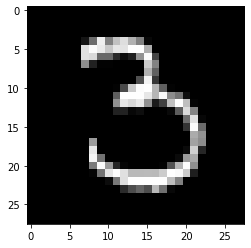

In [ ]:
def show_pred(im, y=None):
  with torch.no_grad():
    im_cv = im.numpy().transpose(1,2,0).squeeze()
    im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

    plt.imshow(im_rgb);
    pred = model(im.unsqueeze(0))

    print(f'Prediction: {torch.argmax(pred)}')
    if y is not None:
      print(f'Actual: {y}')

im = random.choice(test_dl.dataset)
show_pred(im[0], im[1])

In [ ]:
for name, param in model.named_parameters():
  print(name)